In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
# import data
df = pd.read_csv('o8t_testdata.csv')

In [3]:
pd.set_option('display.max_columns', None)
df.head()

,Subject_ID,Label,Gender,Age,Education,Height,Weight,History of cerebrovascular disease,History of hypertension,History of diabetes,History of coronary heart disease,History of hyperlipidemia,History of anemia,History of CO poisoning,History of general anesthesia during surgery,History of abnormal thyroid function,History of traumatic brain injury,Family history of dementia,Smoking history,Drinking history,Unnamed: 21,NPI,MoCAB,MMSE,IADL,HAMA,HAMD,C1 HVLT(immediate memory),C5 HVLT delayed recall 5min,C8 HVLT delayed recall 20min,C4 logical memory WMS,C6 Boston Naming Test,C3 articulateness and verbal fluencey-vegetable BNT,C7-STT_A,C7-STT_B,C2 CFT Rey-limitation,C9 CFT Rey-recall,HD1 depressive mood,HD2 guilty,HD3 suicidal,HD7 work & interests,HA6 Total Score of Depressive Mood \n,Total score of Depression core factors,HA1 Anxiety,HA2 Tension,HA3 Fear,HA14 Interview perfomance,Total score of Anxiety factors
0,1,MCI,Male,77,165.0,90.0,9,Yes,Yes,No,No,Yes,No,No,Yes,No,No,Yes,No,No,NaN,0.0,14.0,20.0,14.0,4.0,3.0,17.0,3.0,3.0,6.0,19.0,13.0,0,218,30.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Dementia,Male,81,169.0,70.0,0,Yes,Yes,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,NaN,3.0,12.0,19.0,20.0,5.0,1.0,10.0,0.0,0.0,0.0,19.0,8.0,Unable to complete,Unable to complete,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,3,Normal,Female,77,155.0,55.0,12,No,Yes,No,Yes,Yes,No,No,No,No,No,No,No,No,NaN,1.0,22.0,28.0,14.0,6.0,2.0,22.0,10.0,10.0,12.0,26.0,16.0,68,150,36.0,14.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0
3,4,Normal,Male,75,169.0,75.0,9,No,No,No,No,No,No,No,No,No,No,No,No,No,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Normal,Male,68,NaN,NaN,9,No,No,No,No,No,No,No,No,No,No,No,No,No,NaN,0.0,24.0,28.0,14.0,2.0,1.0,23.0,9.0,8.0,8.0,27.0,15.0,34,94,36.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Looking at this subset, we can clearly see there are missing values and sentinel values to signify missing values such as 'Unable to complete'. Column 'Unnamed: 21 seems empty which we will check and remove. 

In [4]:
# drop columns with more than 80% null values
df.dropna(thresh = df.shape[0]*0.2, how = 'all', axis = 1, inplace = True)
df.drop(columns=['Subject_ID'], inplace=True)

I decided to drop any column with more than 80% null values as that will not add any value to the model. I'm also dropping 'Subject ID' column which is a subject identifier and will not add value to a ML model.

In [5]:
df.dtypes

Label                                                   object
Gender                                                  object
Age                                                      int64
Education                                              float64
Height                                                 float64
Weight                                                   int64
History of cerebrovascular disease                      object
History of hypertension                                 object
History of diabetes                                     object
History of coronary heart disease                       object
History of hyperlipidemia                               object
History of anemia                                       object
History of CO poisoning                                 object
History of general anesthesia during surgery            object
History of abnormal thyroid function                    object
History of traumatic brain injury                      

This has a mix of numerical and categorical columns. Label column will be used to build the classification model. Let us look at the distribution of labels.

<AxesSubplot:>

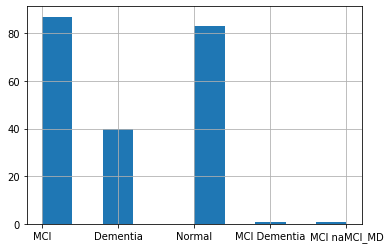

In [6]:
df['Label'].hist()

It appears that this is a multi-class classification problem and the classes of interest are 'Normal', 'MCI', and 'Dementia'. I am going to disregard 'MCI Dementia' and 'MCI naMCI_MD' classes as they only have one instance each which will not be enough to build a model. We can also note that distribution of MCI and Normal patients are fairly similar in numbers whereas patients with Dementia are less than half. Due to this imbalance, we will need to pay particular attention to the performance metrics we'll be using. 

In [7]:
#drop any row that has a null value in Label column
df.dropna(subset=['Label'], inplace=True)
#drop the rows that has MCI Dementia and MCI naMCI_MD
df = df[~df['Label'].isin(['MCI Dementia', 'MCI naMCI_MD'])]

We will look at the distribution of demographic variables such as Age, Education and Gender with respect to patient diagnosis. It appears none of these carry significant differentiating power. 

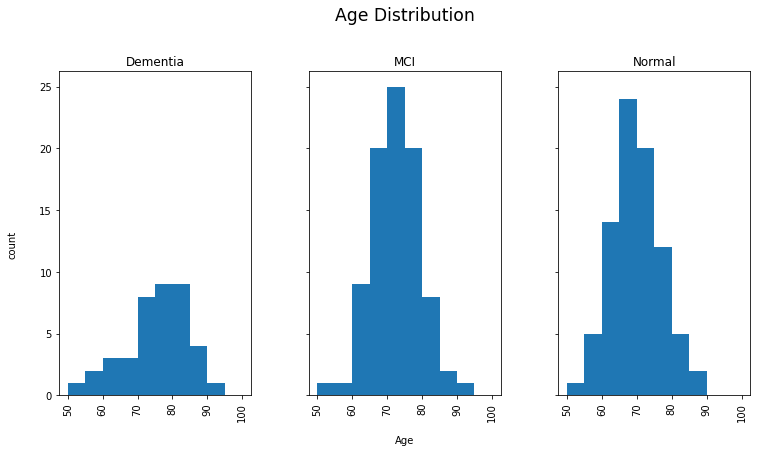

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,6))

#plot distribution of Age grouped by the diagnosis
df['Age'].hist(by=df['Label'], range=[50, 100], align='mid', ax=axes)
plt.suptitle('Age Distribution', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Age', ha='center')
fig.text(0.04, 0.5, 'count', va='center', rotation='vertical')
plt.savefig('AgeDistro.png', bbox_inches='tight')

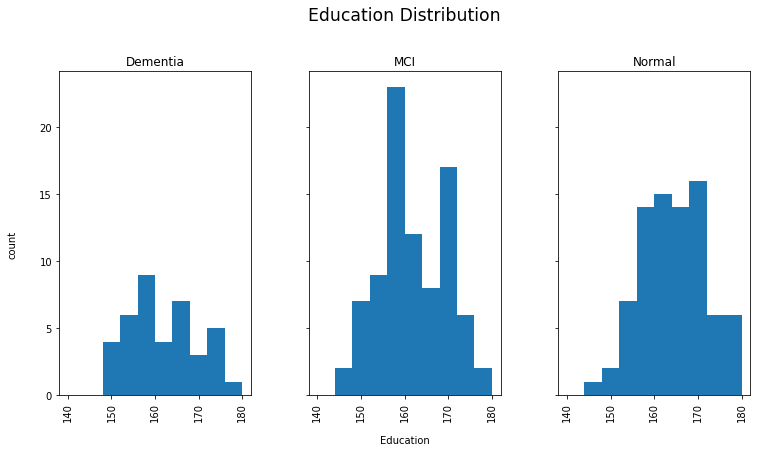

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,6))

#plot distribution of Education grouped by the diagnosis
df['Education'].hist(by=df['Label'], range=[140, 180], align='mid', ax=axes)
plt.suptitle('Education Distribution', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Education', ha='center')
fig.text(0.04, 0.5, 'count', va='center', rotation='vertical')
plt.savefig('EduDistro.png', bbox_inches='tight')

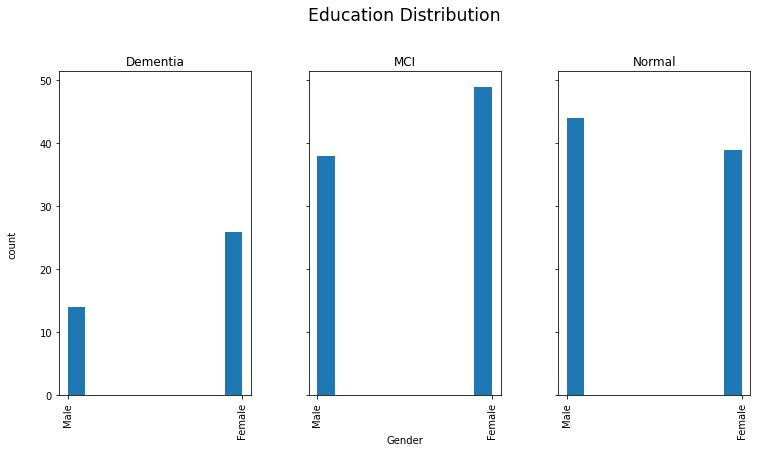

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,6))

#plot distribution of Education grouped by the diagnosis
df['Gender'].hist(by=df['Label'], align='mid', ax=axes)
plt.suptitle('Education Distribution', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Gender', ha='center')
fig.text(0.04, 0.5, 'count', va='center', rotation='vertical')
plt.savefig('GenderDistro.png', bbox_inches='tight')

In [11]:
#are there any null values?
df.isnull().sum()

Label                                                  0
Gender                                                 0
Age                                                    0
Education                                              2
Height                                                 2
Weight                                                 0
History of cerebrovascular disease                     0
History of hypertension                                0
History of diabetes                                    0
History of coronary heart disease                      0
History of hyperlipidemia                              0
History of anemia                                      0
History of CO poisoning                                0
History of general anesthesia during surgery           0
History of abnormal thyroid function                   0
History of traumatic brain injury                      0
Family history of dementia                             0
Smoking history                

It appears that there are no null values in the categorical columns. For null values in numerical columns, I'm going to use mean imputation which will replace the null values by the mean of that column. Before doing that though, I am going to replace sentinel values in C7-STT_A and C7-STT_B and convert it to a numerical column. 

In [12]:
df['C7-STT_A'].replace(['Unable to complete'], '', inplace=True)
df['C7-STT_B'].replace(['Unable to complete'], '', inplace=True)
df[['C7-STT_A', 'C7-STT_B']] = df[['C7-STT_A', 'C7-STT_B']].apply(pd.to_numeric)

In [13]:
df.isnull().sum()

Label                                                   0
Gender                                                  0
Age                                                     0
Education                                               2
Height                                                  2
Weight                                                  0
History of cerebrovascular disease                      0
History of hypertension                                 0
History of diabetes                                     0
History of coronary heart disease                       0
History of hyperlipidemia                               0
History of anemia                                       0
History of CO poisoning                                 0
History of general anesthesia during surgery            0
History of abnormal thyroid function                    0
History of traumatic brain injury                       0
Family history of dementia                              0
Smoking histor

It appears that more than 20% of C7-STT_B is missing, while we could do mean imputation, this may add an inadvertent bias, especially considering the low sample size. Therefore, I will remove C7-STT_B but retain C7-STT_A after mean imputation. STT_A and STT_B evaluate the executive functions so retaining at least one is warranted despite the high number of missing values on C7-STT_A as well.

In [14]:
df.drop(columns=['C7-STT_B'], inplace=True)

In [15]:
#separate the dataset into data and labels
df_x = df.drop('Label', axis=1)
y = df['Label']

#identify the numerical colums to do mean imputation for missing values
numerical_columns = df_x.select_dtypes(include='number').columns 
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df_x[numerical_columns] = imputer.fit_transform(df_x[numerical_columns])

In [16]:
df_x.isnull().sum()

Gender                                                 0
Age                                                    0
Education                                              0
Height                                                 0
Weight                                                 0
History of cerebrovascular disease                     0
History of hypertension                                0
History of diabetes                                    0
History of coronary heart disease                      0
History of hyperlipidemia                              0
History of anemia                                      0
History of CO poisoning                                0
History of general anesthesia during surgery           0
History of abnormal thyroid function                   0
History of traumatic brain injury                      0
Family history of dementia                             0
Smoking history                                        0
Drinking history               

As can be seen, there are no missing values in the dataset now. Finally, we will explore the summary statistics of the dataset and will look at highly correlated variables in the dataset. It appears some variables are highly correlated, for instance MMSE and NPI. We may able to refrain from conducting the highly correlated tests if needed and will further look into this by exploring the importance each of these variables have to make an automated diagnosis.

In [17]:
df.describe()

,Age,Education,Height,Weight,NPI,MoCAB,MMSE,IADL,HAMA,HAMD,C1 HVLT(immediate memory),C5 HVLT delayed recall 5min,C8 HVLT delayed recall 20min,C4 logical memory WMS,C6 Boston Naming Test,C3 articulateness and verbal fluencey-vegetable BNT,C7-STT_A,C2 CFT Rey-limitation,C9 CFT Rey-recall,HD1 depressive mood,HD2 guilty,HD3 suicidal,HD7 work & interests,HA6 Total Score of Depressive Mood \n,Total score of Depression core factors,HA1 Anxiety,HA2 Tension,HA3 Fear,HA14 Interview perfomance,Total score of Anxiety factors
count,210.000000,208.000000,208.000000,210.000000,208.000000,208.000000,208.000000,208.000000,208.000000,209.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,191.000000,206.000000,206.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,71.528571,162.197115,61.990385,10.447619,2.735577,17.134615,22.721154,17.884615,7.086538,5.444976,14.907767,3.970874,4.048544,6.655340,20.033981,11.500000,75.753927,27.393204,9.626214,0.464115,0.263158,0.086124,0.368421,0.636364,1.818182,0.745192,0.533654,0.149038,0.120192,1.548077
std,7.603301,7.883487,9.816795,4.537944,4.714279,7.302382,6.397398,6.062170,4.918879,4.428718,7.280863,3.675778,3.676899,3.453192,5.911032,4.671397,38.405416,11.153289,8.782527,0.796570,0.666962,0.328529,0.761551,0.833100,2.617518,1.006009,0.878526,0.483445,0.380663,1.960380
min,50.000000,138.000000,41.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,66.000000,156.000000,55.000000,9.000000,0.000000,11.750000,20.000000,14.000000,4.000000,2.000000,10.000000,0.000000,0.000000,4.000000,16.000000,8.000000,51.000000,23.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,71.000000,162.000000,60.000000,9.000000,1.000000,18.000000,25.000000,15.000000,6.000000,4.000000,15.000000,4.000000,4.000000,7.000000,21.000000,11.500000,66.000000,33.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,77.000000,169.000000,68.000000,14.000000,3.000000,23.000000,27.000000,19.250000,9.250000,8.000000,20.000000,7.000000,7.000000,9.000000,25.000000,15.000000,88.500000,35.000000,16.750000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,2.000000
max,92.000000,182.000000,92.000000,20.000000,27.000000,29.000000,30.000000,54.000000,26.000000,21.000000,31.000000,12.000000,12.000000,14.000000,29.000000,22.000000,232.000000,36.000000,29.000000,3.000000,3.000000,2.000000,3.000000,3.000000,13.000000,3.000000,3.000000,2.000000,2.000000,8.000000


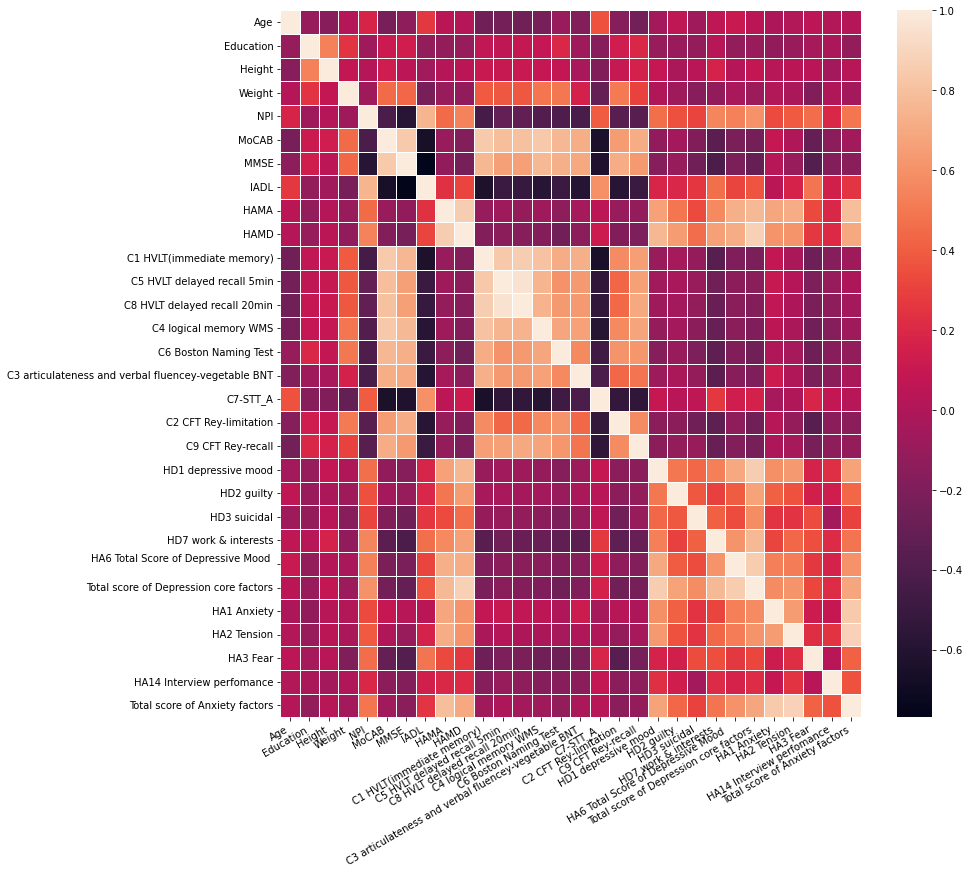

In [18]:
corrmat = df.corr()
plt.figure(figsize=(13, 13))
sns.heatmap(corrmat, vmax=1, linewidths=.5)
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()

I am going to create a Random Forest Model as a baseline to classify between the three classes; Normal, MCI and Dementia. I will be converting the categorical features to numerical features using One Hot encoding and use all features without any feature engineering for the baseline model. I am also setting hyperparameters for the model using heuristics intially. I will use 5-fold cross validation for evaluation. 

In [19]:
#find categorical columns and use one hot encoding to conver them to numerical columns
cat_columns = df_x.select_dtypes(exclude='number').columns
df_x = pd.get_dummies(df_x, columns=cat_columns, drop_first=True)

In [20]:
df_x.head()

,Age,Education,Height,Weight,NPI,MoCAB,MMSE,IADL,HAMA,HAMD,C1 HVLT(immediate memory),C5 HVLT delayed recall 5min,C8 HVLT delayed recall 20min,C4 logical memory WMS,C6 Boston Naming Test,C3 articulateness and verbal fluencey-vegetable BNT,C7-STT_A,C2 CFT Rey-limitation,C9 CFT Rey-recall,HD1 depressive mood,HD2 guilty,HD3 suicidal,HD7 work & interests,HA6 Total Score of Depressive Mood \n,Total score of Depression core factors,HA1 Anxiety,HA2 Tension,HA3 Fear,HA14 Interview perfomance,Total score of Anxiety factors,Gender_Male,History of cerebrovascular disease_Yes,History of hypertension_Yes,History of diabetes_Yes,History of coronary heart disease_Yes,History of hyperlipidemia_Yes,History of anemia_Yes,History of CO poisoning_Yes,History of general anesthesia during surgery_Yes,History of abnormal thyroid function_Yes,History of traumatic brain injury_Yes,Family history of dementia_Yes,Smoking history_Yes,Drinking history_Yes
0,77.0,165.000000,90.000000,9.0,0.000000,14.000000,20.000000,14.000000,4.0,3.0,17.000000,3.000000,3.000000,6.00000,19.000000,13.0,0.000000,30.000000,20.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0,0,1,0,0,1,0,0,1,0,0
1,81.0,169.000000,70.000000,0.0,3.000000,12.000000,19.000000,20.000000,5.0,1.0,10.000000,0.000000,0.000000,0.00000,19.000000,8.0,75.753927,13.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,1,1,0,0,1,0,0,1,1,0,1,0,0
2,77.0,155.000000,55.000000,12.0,1.000000,22.000000,28.000000,14.000000,6.0,2.0,22.000000,10.000000,10.000000,12.00000,26.000000,16.0,68.000000,36.000000,14.000000,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,0,0,1,0,1,1,0,0,0,0,0,0,0,0
3,75.0,169.000000,75.000000,9.0,2.735577,17.134615,22.721154,17.884615,4.0,4.0,14.907767,3.970874,4.048544,6.65534,20.033981,11.5,75.753927,27.393204,9.626214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,68.0,162.197115,61.990385,9.0,0.000000,24.000000,28.000000,14.000000,2.0,1.0,23.000000,9.000000,8.000000,8.00000,27.000000,15.0,34.000000,36.000000,26.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
clf = RandomForestClassifier(max_depth=10, n_estimators=50, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, df_x, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Balanced Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Balanced Accuracy: 0.871 (0.081)


This model yields rather reasonable results, especially as we are looking at Balanced Accuracy which is defined as the average of recall obtained on each class. This is a good measure that takes into account the imbalanced nature of this dataset. However, let us further examine our results by splitting this dataset into a training and test set and further evaluating the performance on the test set.

In [22]:
#use label encoder to convert the categorical labels into numerical ones
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['Dementia', 'MCI', 'Normal'], dtype=object)

In [23]:
#split the dataset into train and test set and train a random forest classifier on the train set. 
X_train, X_test, y_train, y_test = train_test_split(df_x, y, test_size = 0.2, random_state = 42)
clf2 = RandomForestClassifier(max_depth=10, random_state=0)
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
print("Accuracy:",metrics.balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.9666666666666667


In [24]:
#a set of other metrics are also calculated using confusion matrix. It should be noted that the calculations are the mean of individual binary classification measures.
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

In [25]:
print("Specificity:", np.mean(TNR))
print("Precision:", np.mean(PPV))
print("Overall Accuracy:", np.mean(ACC))

Specificity: 0.9743589743589745
Precision: 0.9629629629629629
Overall Accuracy: 0.9682539682539683


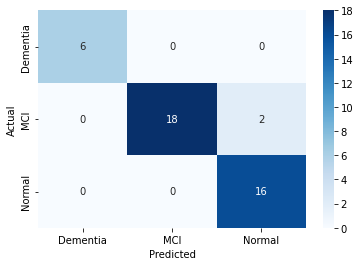

In [26]:
#build the confusion matrix using SNS
c_mat = pd.DataFrame(data=np.column_stack((le.inverse_transform(y_test),le.inverse_transform(y_pred))), columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(c_mat['y_Actual'], c_mat['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.savefig('confusion.png', bbox_inches='tight')
plt.show()

In [27]:
#examine the wrongly predicted instances
indices = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]
wrong_predictions = X_test.iloc[indices,:]
wrong_predictions

,Age,Education,Height,Weight,NPI,MoCAB,MMSE,IADL,HAMA,HAMD,C1 HVLT(immediate memory),C5 HVLT delayed recall 5min,C8 HVLT delayed recall 20min,C4 logical memory WMS,C6 Boston Naming Test,C3 articulateness and verbal fluencey-vegetable BNT,C7-STT_A,C2 CFT Rey-limitation,C9 CFT Rey-recall,HD1 depressive mood,HD2 guilty,HD3 suicidal,HD7 work & interests,HA6 Total Score of Depressive Mood \n,Total score of Depression core factors,HA1 Anxiety,HA2 Tension,HA3 Fear,HA14 Interview perfomance,Total score of Anxiety factors,Gender_Male,History of cerebrovascular disease_Yes,History of hypertension_Yes,History of diabetes_Yes,History of coronary heart disease_Yes,History of hyperlipidemia_Yes,History of anemia_Yes,History of CO poisoning_Yes,History of general anesthesia during surgery_Yes,History of abnormal thyroid function_Yes,History of traumatic brain injury_Yes,Family history of dementia_Yes,Smoking history_Yes,Drinking history_Yes
197,69.0,159.0,60.0,9.0,1.0,19.0,24.0,19.0,13.0,7.0,22.0,8.0,8.0,7.0,26.0,18.0,33.0,36.0,17.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
162,87.0,170.0,55.0,9.0,4.0,20.0,27.0,14.0,7.0,4.0,11.0,3.0,3.0,6.0,26.0,18.0,74.0,34.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,1,0,0,1,0,0,1,0,0,0,0,0


We can see from the confusion matrix that 2 patients with MCI have been predicted as Normal patients. This is reasonable as these patients are closer to Normal than MCI at a glance; for instance, their MMSE is 24 and 27 respectively. If your MMSE is above 24, you are considered to be normal cognition. We could further test this by looking at what are the most important predictors for the model.

<BarContainer object of 44 artists>

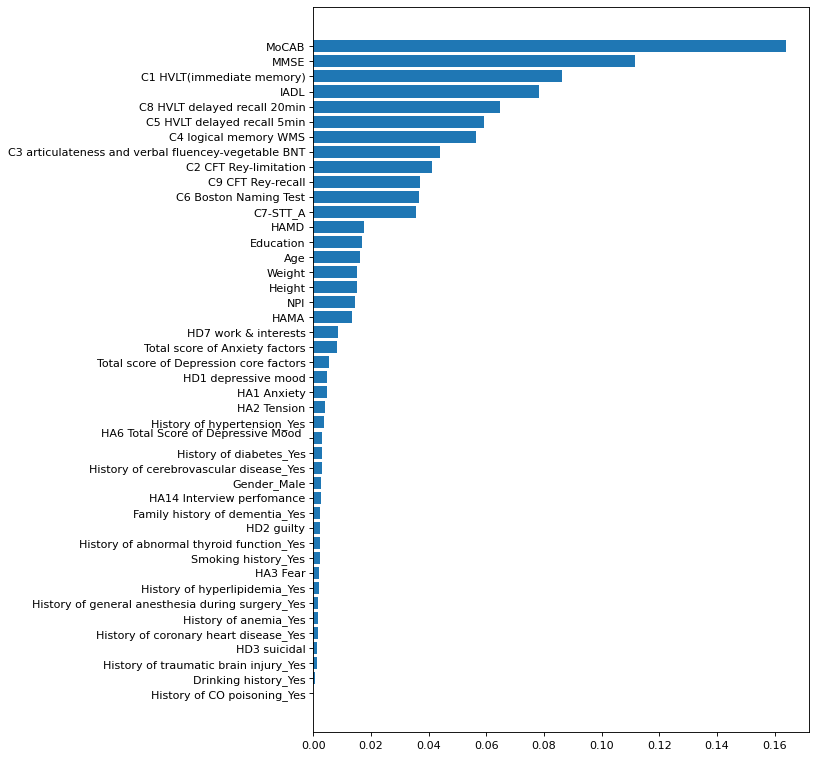

In [28]:
#plot the most important features for the model
feature_names = X_train.columns
plt.figure(figsize=(8, 12), dpi=80)
sorted_idx = clf2.feature_importances_.argsort()
plt.barh(feature_names[sorted_idx], clf2.feature_importances_[sorted_idx])

In [29]:
#get the average values for numerical columns grouped by each class
df.groupby('Label').mean()

,Age,Education,Height,Weight,NPI,MoCAB,MMSE,IADL,HAMA,HAMD,C1 HVLT(immediate memory),C5 HVLT delayed recall 5min,C8 HVLT delayed recall 20min,C4 logical memory WMS,C6 Boston Naming Test,C3 articulateness and verbal fluencey-vegetable BNT,C7-STT_A,C2 CFT Rey-limitation,C9 CFT Rey-recall,HD1 depressive mood,HD2 guilty,HD3 suicidal,HD7 work & interests,HA6 Total Score of Depressive Mood \n,Total score of Depression core factors,HA1 Anxiety,HA2 Tension,HA3 Fear,HA14 Interview perfomance,Total score of Anxiety factors
Label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Dementia,74.775000,160.675000,60.150000,7.475000,7.875000,6.615385,12.375000,26.575000,8.550000,7.850000,4.894737,0.000000,0.000000,1.973684,12.342105,5.473684,118.208333,13.394737,0.000000,0.775000,0.475000,0.275000,1.000000,1.050000,3.575000,0.800000,0.675000,0.450000,0.275000,2.200000
MCI,71.988506,161.425287,61.603448,9.735632,1.977011,15.298851,23.197674,16.802326,7.290698,5.534884,13.643678,2.563218,2.609195,5.908046,19.494253,11.298851,85.325581,27.793103,7.195402,0.406977,0.209302,0.034884,0.290698,0.627907,1.569767,0.674419,0.534884,0.116279,0.081395,1.406977
Normal,69.481928,163.777778,63.314815,12.626506,1.012346,24.085366,27.268293,14.780488,6.158537,4.192771,20.962963,7.345679,7.493827,9.654321,24.222222,14.543210,53.012346,33.530864,16.753086,0.373494,0.216867,0.048193,0.144578,0.445783,1.228916,0.792683,0.463415,0.036585,0.085366,1.378049


In [30]:
wrong_predictions

,Age,Education,Height,Weight,NPI,MoCAB,MMSE,IADL,HAMA,HAMD,C1 HVLT(immediate memory),C5 HVLT delayed recall 5min,C8 HVLT delayed recall 20min,C4 logical memory WMS,C6 Boston Naming Test,C3 articulateness and verbal fluencey-vegetable BNT,C7-STT_A,C2 CFT Rey-limitation,C9 CFT Rey-recall,HD1 depressive mood,HD2 guilty,HD3 suicidal,HD7 work & interests,HA6 Total Score of Depressive Mood \n,Total score of Depression core factors,HA1 Anxiety,HA2 Tension,HA3 Fear,HA14 Interview perfomance,Total score of Anxiety factors,Gender_Male,History of cerebrovascular disease_Yes,History of hypertension_Yes,History of diabetes_Yes,History of coronary heart disease_Yes,History of hyperlipidemia_Yes,History of anemia_Yes,History of CO poisoning_Yes,History of general anesthesia during surgery_Yes,History of abnormal thyroid function_Yes,History of traumatic brain injury_Yes,Family history of dementia_Yes,Smoking history_Yes,Drinking history_Yes
197,69.0,159.0,60.0,9.0,1.0,19.0,24.0,19.0,13.0,7.0,22.0,8.0,8.0,7.0,26.0,18.0,33.0,36.0,17.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
162,87.0,170.0,55.0,9.0,4.0,20.0,27.0,14.0,7.0,4.0,11.0,3.0,3.0,6.0,26.0,18.0,74.0,34.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,1,0,0,1,0,0,1,0,0,0,0,0


Looking at the feature importance, we can see that MoCAB, MMSE, C1 HVLT(immediate memory), IADL and C8 HVLT delayed recall 20min are the 5 most important feature the model uses to differentiate between the three classes. When we inspect patient 197, their MoCAB is 19 which is in between MCI and Normal; their MMSE is 24 which is closer to the average of Normal patients than those with MCI; their C1 HVLT is 22 which is closer to Normal than MCI; their IADL is 19 which closer to MCI than Normal and their C8 HVLT is 8 which is closer to the Normal than MCI. We can reasonably ascertain this is why the model has predicted patient 197 as Normal rather than a patient with MCI. 

When we inspect patient 162, their MoCAB is 20 which is closer to Normal than MCI; their MMSE is 27 which is closer to the average of Normal patients than those with MCI; their C1 HVLT is 11 which is closer to MCI than Normal; their IADL is 19 which is closer to MCI than Normal and their C8 HVLT is 3 which is closer to MCI than Normal. In this case, top two features are biased towards a Normal patient and the other three features are biased towards MCI. Given that the model considers the first two features as the most important by a significant margin, we can also reasonably ascertain this is why the model has predicted patient 162 as Normal rather than a patient with MCI.  